# Similarity Search


PDF → 청크 → 임베딩 → 벡터DB → 검색 순으로 진행됩니다.

### 1) 라이브러리 임포트 + PDF 로더


- 목적: PDF를 페이지별 텍스트로 로딩합니다(`pypdf.PdfReader`).
- 동작: 50자 이하 텍스트 페이지를 제외하고 `[{page, content}]` 리스트로 반환합니다.
- 팁: 추후 출처 표시를 위해 `page` 메타를 유지합니다. 빈/잡음 페이지 필터링 임계값(50자)은 데이터에 맞게 조정 필요.

In [30]:
import streamlit as st
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import chromadb
from langchain_community.embeddings import OllamaEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pypdf import PdfReader
import numpy as np

# PDF 파일 로드
def load_pdf(pdf_path):
    reader = PdfReader(pdf_path)
    documents = []
    
    for page_num, page in enumerate(reader.pages, 1):
        text = page.extract_text()
        if len(text.strip()) > 50:
            documents.append({
                "page": str(page_num),
                "content": text.strip()
            })
    
    print(f"{len(documents)}개 페이지 로드 완료")
    return documents

### 2) 텍스트 청크 생성


- 목적: 긴 페이지 텍스트를 RecursiveCharacterTextSplitter를 사용하여 `chunk_size` 기준으로 분할합니다.
- 파라미터: `chunk_size=1000`(문자 수 기준). 'chink_overlap=200(overlap) 사용
- 장점: 검색/임베딩 최적화

In [31]:
# 청크 생성
def create_chunks(documents, chunk_size, chunk_overlap):

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        separators=["\n\n", "\n", "。", ".", " ", ""]
    )

    chunks = []
    chunk_id = 0
    
    for doc in documents:
        split_texts = text_splitter.split_text(doc["content"])
        
        for text in split_texts:
            if text.strip():
                chunks.append({
                    "id": f"chunk_{chunk_id}",
                    "content": text.strip(),
                    "page": doc["page"]
                })
                chunk_id += 1
    
    print(f"{len(chunks)}개 청크 생성 완료")
    return chunks

### 3) 임베딩 + Chroma 컬렉션 구성


- 목적: Ollama 임베딩(`nomic-embed-text`)으로 청크를 벡터화하고 Chroma 컬렉션에 적재합니다.
- 배치: `batch_size=10`으로 임베딩/적재를 나눠 처리합니다.

In [32]:
# Chroma DB 초기화 및 데이터 추가
def setup_database(chunks, collection_name):
    # Ollama 임베딩 모델 초기화
    ollama_emb = OllamaEmbeddings(model="nomic-embed-text")
    
    # Chroma 클라이언트 생성
    client = chromadb.Client()
    
    # 컬렉션 생성
    collection = client.get_or_create_collection(
        name=collection_name
    )
    
    # 청크를 배치로 처리하여 임베딩 생성 및 추가
    print("임베딩 생성 중...")
    batch_size = 10
    
    for i in range(0, len(chunks), batch_size):
        batch_chunks = chunks[i:i+batch_size]
        texts = [c["content"] for c in batch_chunks]
        
        # Ollama로 임베딩 생성
        embeddings = ollama_emb.embed_documents(texts)
        
        collection.add(
            ids=[c["id"] for c in batch_chunks],
            documents=texts,
            embeddings=embeddings,
            metadatas=[{"page": c["page"]} for c in batch_chunks]
        )
        
        print(f"진행: {min(i+batch_size, len(chunks))}/{len(chunks)}")
    
    print("데이터베이스 추가 완료")
    return collection, ollama_emb

### 4) 유사도 검색 함수


- 목적: 질의를 임베딩해 가장 가까운 문서 청크를 조회합니다.
- 출력: 상위 `n_results`개의 문서, 메타데이터(페이지), 코사인 유사도(cosine similarity).

In [33]:
# 검색
def search(collection, ollama_emb, query, n_results=3):
    # 쿼리 임베딩 생성
    query_embedding = ollama_emb.embed_query(query)
    
    # 검색 수행
    results = collection.query(
        query_embeddings=[query_embedding],
        n_results=n_results,
        include=["documents", "metadatas", "embeddings"]
    )
    print(f"질문: {query}")
    print("-" * 60)
    print(f"상위 {n_results}개 결과 검색")
    print("-" * 60)
    # 쿼리 임베딩을 numpy 배열로 변환
    query_emb_array = np.array(query_embedding)
    
    for i, (doc, meta, emb) in enumerate(zip(
        results["documents"][0],
        results["metadatas"][0],
        results["embeddings"][0]
    ), 1):
        # 문서 임베딩을 numpy 배열로 변환
        doc_emb_array = np.array(emb)
        
        # 코사인 유사도 계산
        cosine_sim = np.dot(query_emb_array, doc_emb_array) / (
            np.linalg.norm(query_emb_array) * np.linalg.norm(doc_emb_array)
        )
        
        print(f"[결과 {i}] 문서 페이지: {meta['page']}, 코사인 유사도: {cosine_sim:.3f}")
        print(doc[:100] + "...")

In [42]:
def visualize_embeddings(collection, queries, ollama_emb):
    plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
    plt.rcParams['axes.unicode_minus'] = False  # 한글 폰트 사용 시 마이너스 깨짐 방지
    # 모든 임베딩 가져오기
    all_data = collection.get(include=["embeddings", "metadatas"])
    embeddings = np.array(all_data["embeddings"])
    
    # 차원 축소 (PCA)
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(embeddings)
    
    # 플롯
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5, label='Documents')
    
    # 쿼리도 표시
    for query in queries:
        query_emb = ollama_emb.embed_query(query)
        query_2d = pca.transform([query_emb])
        plt.scatter(query_2d[0, 0], query_2d[0, 1], marker='*', s=200, label=query)
    
    plt.legend()
    plt.title('Document Embeddings Visualization')
    plt.show()


### 5) 엔드투엔드 실행


- 입력: `test_pdf.pdf` 파일을 로드하고 → 청크 생성 → 컬렉션 구성 → 예시 질의 리스트로 검색을 수행합니다.

In [36]:

# PDF 파일 경로
pdf_path = "test_pdf.pdf"
    
# 1. PDF 로드
documents = load_pdf(pdf_path)
    
# 2. 청크 생성
chunks = create_chunks(documents, chunk_size=1000, chunk_overlap=200)
    
# 3. 데이터베이스 설정
collection, ollama_emb = setup_database(chunks, collection_name="ai4science")

39개 페이지 로드 완료
75개 청크 생성 완료
임베딩 생성 중...
진행: 10/75
진행: 20/75
진행: 30/75
진행: 40/75
진행: 50/75
진행: 60/75
진행: 70/75
진행: 75/75
데이터베이스 추가 완료


In [39]:
# 4. 검색 테스트
queries = [
    "AlphaFold는 무엇인가?",
    "연구 패러다임의 변화",
    "자율실험실의 개념"
]
    
for query in queries:
    search(collection, ollama_emb, query)
    print("\n")

질문: AlphaFold는 무엇인가?
------------------------------------------------------------
상위 3개 결과 검색
------------------------------------------------------------
[결과 1] 문서 페이지: 30, 코사인 유사도: 0.637
SPRi 이슈리포트 IS-208과학을 위한 AI(AI4Science) 연구의 패러다임을 바꾸다 
25
참고1구글의 생명분야 단백질 구조 예측 인공지능 알파폴드(AlphaFold)<...
[결과 2] 문서 페이지: 30, 코사인 유사도: 0.637
SPRi 이슈리포트 IS-208과학을 위한 AI(AI4Science) 연구의 패러다임을 바꾸다 
25
참고1구글의 생명분야 단백질 구조 예측 인공지능 알파폴드(AlphaFold)<...
[결과 3] 문서 페이지: 6, 코사인 유사도: 0.542
SPRi 이슈리포트 IS-208과학을 위한 AI(AI4Science) 연구의 패러다임을 바꾸다 
1
I. 연구배경1.1 소프트웨어의 발전과 연구 혁신□소프트웨어 기술의 발전은 연구...


질문: 연구 패러다임의 변화
------------------------------------------------------------
상위 3개 결과 검색
------------------------------------------------------------
[결과 1] 문서 페이지: 26, 코사인 유사도: 0.689
SPRi 이슈리포트 IS-208과학을 위한 AI(AI4Science) 연구의 패러다임을 바꾸다 
21
Ⅲ. 요약과 시사점3.1 요약□연구 패러다임의 전환: 다섯 번째 과학 혁명과 ...
[결과 2] 문서 페이지: 26, 코사인 유사도: 0.689
SPRi 이슈리포트 IS-208과학을 위한 AI(AI4Science) 연구의 패러다임을 바꾸다 
21
Ⅲ. 요약과 시사점3.1 요약□연구 패러다임의 전환: 다섯 번째 과학 혁명과 ...
[결과 

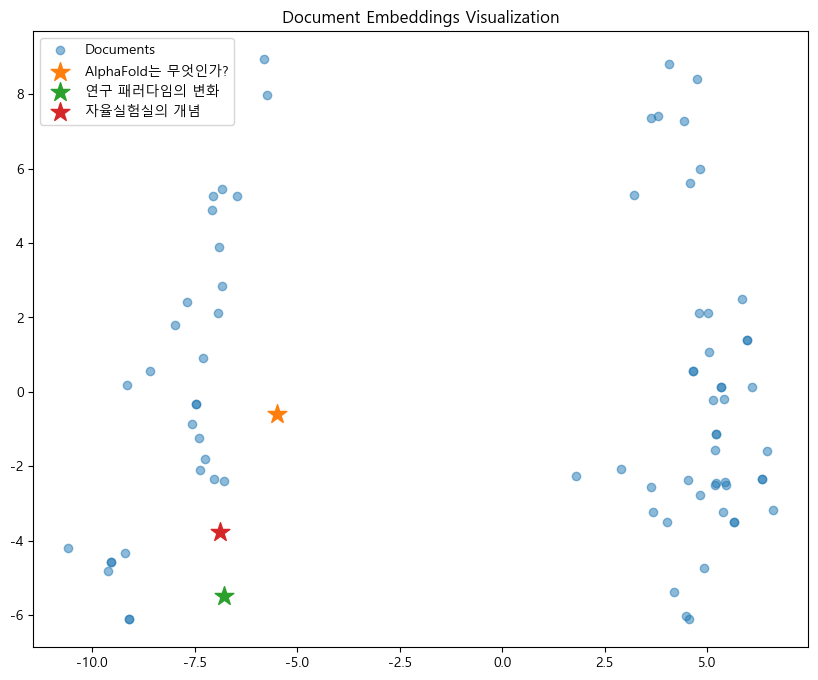

In [43]:
visualize_embeddings(collection, queries, ollama_emb)